In [1]:
# Trader Behavior vs Market Sentiment

In [2]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
from IPython.display import display, HTML

# For simple modeling / tests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import scipy.stats as stats

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Visualization defaults
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 5)


In [3]:
# Root submission directory
CANDIDATE_NAME = "Alfiya_Mulla"
ROOT = Path(f"ds_{CANDIDATE_NAME}")
CSV_DIR = ROOT / "csv_files"
OUT_DIR = ROOT / "outputs"
NOTEBOOKS_DIR = ROOT

for d in [ROOT, CSV_DIR, OUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Created directories:", ROOT, CSV_DIR, OUT_DIR)


Created directories: ds_Alfiya_Mulla ds_Alfiya_Mulla/csv_files ds_Alfiya_Mulla/outputs


In [4]:
HYPERLIQUID_PATH = "/content/historical_data.csv"
SENTIMENT_PATH = "/content/fear_greed_index.csv"

print("Hyperliquid path:", HYPERLIQUID_PATH)
print("Sentiment path   :", SENTIMENT_PATH)


Hyperliquid path: /content/historical_data.csv
Sentiment path   : /content/fear_greed_index.csv


In [5]:
#robust loader with basic checks
def safe_read_csv(path, nrows=None):
    path = str(path)
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}. Upload to Colab or mount Drive and update path.")
    df = pd.read_csv(path, nrows=nrows)
    print(f"Loaded {path} -> {df.shape[0]} rows, {df.shape[1]} cols")
    return df

#  read both files
try:
    trades = safe_read_csv(HYPERLIQUID_PATH)
    sentiment = safe_read_csv(SENTIMENT_PATH)
except FileNotFoundError as e:
    raise e

display(trades.head())
display(sentiment.head())


Loaded /content/historical_data.csv -> 167964 rows, 16 cols
Loaded /content/fear_greed_index.csv -> 2644 rows, 4 cols


/tmp/ipython-input-4289641488.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, nrows=nrows)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [6]:
# Preliminary cleaning & type casting
# - Normalize column names (lowercase, underscores)
# - Parse datetimes for trading records and sentiment
def normalize_cols(df):
    df = df.copy()
    df.columns = (df.columns
                    .str.strip()
                    .str.lower()
                    .str.replace(' ', '_')
                    .str.replace('-', '_')
                    .str.replace(r'[^\w_]', '', regex=True))
    return df

trades = normalize_cols(trades)
sentiment = normalize_cols(sentiment)

# Identify likely datetime columns
print("Trades columns:", trades.columns.tolist())
print("Sentiment columns:", sentiment.columns.tolist())

# Parse datetimes columns
def parse_datetime_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            try:
                df[c] = pd.to_datetime(df[c], utc=True, errors='coerce')
                return c
            except Exception:
                pass
    return None

time_col = parse_datetime_col(trades, ['time', 'timestamp', 'date', 'datetime'])
sent_time_col = parse_datetime_col(sentiment, ['date', 'time', 'timestamp', 'datetime'])

print("Detected trades time col:", time_col)
print("Detected sentiment time col:", sent_time_col)

# If time columns are not found,  then tell user which columns exist
if time_col is None:
    raise ValueError("Could not detect a datetime column in trades. Available columns: " + ", ".join(trades.columns))
if sent_time_col is None:
    raise ValueError("Could not detect a datetime column in sentiment. Available columns: " + ", ".join(sentiment.columns))


Trades columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']
Detected trades time col: timestamp
Detected sentiment time col: date


In [7]:

# Basic numeric columns casting
numeric_cols_guesses = ['execution_price', 'executionprice', 'price', 'size', 'closedpnl', 'leverage', 'qty', 'quantity']
for col in numeric_cols_guesses:
    if col in trades.columns:
        trades[col] = pd.to_numeric(trades[col], errors='coerce')

# Ensure 'size' and 'side' exist. If not, try alternatives.
if 'size' not in trades.columns and 'quantity' in trades.columns:
    trades.rename(columns={'quantity': 'size'}, inplace=True)

if 'side' not in trades.columns and 'direction' in trades.columns:
    trades.rename(columns={'direction': 'side'}, inplace=True)

# sanitize side values
if 'side' in trades.columns:
    trades['side'] = trades['side'].astype(str).str.lower().str.strip()

# Create 'date' column (UTC date) for aggregations
trades['date_utc'] = trades[time_col].dt.tz_convert('UTC').dt.normalize()
sentiment[sent_time_col] = pd.to_datetime(sentiment[sent_time_col], errors='coerce')
if sentiment[sent_time_col].dt.tz is None:
    sentiment['date_utc'] = sentiment[sent_time_col].dt.tz_localize('UTC', ambiguous='NaT', nonexistent='shift_forward').dt.normalize()
else:
    sentiment['date_utc'] = sentiment[sent_time_col].dt.tz_convert('UTC').dt.normalize()

# If sentiment classification column exists but name varies, standardize to 'classification'
for c in ['classification', 'class', 'label', 'fear_greed', 'sentiment']:
    if c in sentiment.columns:
        sentiment.rename(columns={c: 'classification'}, inplace=True)
        break

print("After cleaning: trades shape", trades.shape, "sentiment shape", sentiment.shape)


After cleaning: trades shape (167964, 17) sentiment shape (2644, 5)


In [8]:
#  FEATURE ENGINEERING (TRADE-LEVEL)
# Handles real-world column variations like size_tokens / size_usd
trades = trades.copy()

#Identify correct size column
possible_size_cols = [
    'size', 'qty', 'quantity', 'amount',
    'trade_size', 'position_size', 'size_tokens', 'size_usd'
]
size_col = next((col for col in possible_size_cols if col in trades.columns), None)

if size_col is None:
    raise KeyError(f"No size-like column found! Expected one of: {possible_size_cols}. "
                   f"Available columns: {list(trades.columns)}")

# Pick size_usd over size_tokens if both exist (USD more stable)
if {'size_tokens', 'size_usd'}.issubset(trades.columns):
    print(" Both size_tokens and size_usd found — using size_usd for consistency.")
    size_col = 'size_usd'

# Standardize to 'size'
if size_col != 'size':
    trades.rename(columns={size_col: 'size'}, inplace=True)

# Standardize side/direction column
possible_side_cols = ['side', 'direction', 'trade_side', 'position_side']
side_col = next((col for col in possible_side_cols if col in trades.columns), None)

if side_col is None:
    print("No 'side' column found — assuming all trades are BUY side.")
    trades['side'] = 'buy'
else:
    if side_col != 'side':
        trades.rename(columns={side_col: 'side'}, inplace=True)
    trades['side'] = trades['side'].astype(str).str.lower().str.strip()

# Create signed_size (positive for buy/long, negative for sell/short)
trades['signed_size'] = np.where(
    trades['side'].isin(['buy', 'long', 'b']), trades['size'],
    np.where(trades['side'].isin(['sell', 'short', 's']), -trades['size'], trades['size'])
)

# -Handle closed PnL variations
pnl_candidates = ['closedpnl', 'closed_pnl', 'pnl', 'profit', 'realizedpnl', 'pl']
pnl_col = next((col for col in pnl_candidates if col in trades.columns), None)

if pnl_col is None:
    raise KeyError(f"No PnL column found! Expected one of: {pnl_candidates}")
else:
    if pnl_col != 'closedpnl':
        trades.rename(columns={pnl_col: 'closedpnl'}, inplace=True)

trades['closedpnl'] = pd.to_numeric(trades['closedpnl'], errors='coerce')

# PnL per size
trades['pnl_per_size'] = trades['closedpnl'] / trades['size'].replace({0: np.nan})

#  Win/loss flag
trades['is_win'] = trades['closedpnl'] > 0

#Leverage bucketization
if 'leverage' in trades.columns:
    trades['leverage'] = pd.to_numeric(trades['leverage'], errors='coerce')
    trades['lev_bucket'] = pd.cut(
        trades['leverage'].fillna(1),
        bins=[0, 1.5, 2.5, 5, 10, 20, 1000],
        labels=['<=1.5', '1.5-2.5', '2.5-5', '5-10', '10-20', '>20'],
        include_lowest=True
    )
else:
    trades['lev_bucket'] = 'unknown'

print("Feature engineering complete.")
print(f"Detected trade size column → '{size_col}'")
print(f"Detected PnL column        → '{pnl_col}'")
print(f"Detected side column       → '{side_col}'")

display(
    trades[['date_utc', 'size', 'signed_size', 'closedpnl', 'pnl_per_size', 'is_win', 'lev_bucket']]
    .head(10)
)


 Both size_tokens and size_usd found — using size_usd for consistency.
Feature engineering complete.
Detected trade size column → 'size_usd'
Detected PnL column        → 'closed_pnl'
Detected side column       → 'side'


,date_utc,size,signed_size,closedpnl,pnl_per_size,is_win,lev_bucket
0,1970-01-01 00:00:00+00:00,7872.16,7872.16,0.0,0.0,False,unknown
1,1970-01-01 00:00:00+00:00,127.68,127.68,0.0,0.0,False,unknown
2,1970-01-01 00:00:00+00:00,1150.63,1150.63,0.0,0.0,False,unknown
3,1970-01-01 00:00:00+00:00,1142.04,1142.04,0.0,0.0,False,unknown
4,1970-01-01 00:00:00+00:00,69.75,69.75,0.0,0.0,False,unknown
5,1970-01-01 00:00:00+00:00,11.27,11.27,0.0,0.0,False,unknown
6,1970-01-01 00:00:00+00:00,1151.77,1151.77,0.0,0.0,False,unknown
7,1970-01-01 00:00:00+00:00,272.00,272.00,0.0,0.0,False,unknown
8,1970-01-01 00:00:00+00:00,368.00,368.00,0.0,0.0,False,unknown
9,1970-01-01 00:00:00+00:00,100.00,100.00,0.0,0.0,False,unknown


In [9]:

# DAILY AGGREGATION (All Traders)
# Handles cases where some columns (like leverage) are missing

trades = trades.copy()

# Ensure 'date_utc' exists
if 'date_utc' not in trades.columns:
    raise KeyError("Missing 'date_utc' column. Please check your preprocessing step.")

# Start with base aggregations
agg_dict = {
    'size': ['count', 'sum'],
    'signed_size': 'sum',
    'closedpnl': ['mean', 'median'],
    'is_win': 'mean'
}

# Conditionally add leverage if available
if 'leverage' in trades.columns:
    agg_dict['leverage'] = ['mean', 'median']

# Conditionally add pnl_per_size if available
if 'pnl_per_size' in trades.columns:
    agg_dict['pnl_per_size'] = 'mean'

# Perform the aggregation
daily = trades.groupby('date_utc').agg(agg_dict)

# Flatten MultiIndex columns (for nice names)
daily.columns = ['_'.join(col).strip('_') for col in daily.columns]
daily = daily.reset_index()

# Rename for consistency
rename_map = {
    'size_count': 'trades_count',
    'size_sum': 'total_volume',
    'signed_size_sum': 'signed_volume',
    'closedpnl_mean': 'avg_pnl',
    'closedpnl_median': 'median_pnl',
    'is_win_mean': 'win_rate',
    'pnl_per_size_mean': 'avg_pnl_per_size'
}
daily.rename(columns=rename_map, inplace=True)

# Add day-of-week for temporal analysis
daily['dow'] = daily['date_utc'].dt.day_name()

# Merge sentiment
if 'classification' not in sentiment.columns:
    # Try fallback column names
    possible = [c for c in sentiment.columns if 'class' in c or 'sent' in c or 'greed' in c]
    if possible:
        sentiment.rename(columns={possible[0]: 'classification'}, inplace=True)

sent_small = sentiment[['date_utc', 'classification']].drop_duplicates(subset=['date_utc'])
merged = pd.merge(daily, sent_small, on='date_utc', how='left')

#  Summary
print("Daily aggregation complete.")
print(f"Rows in daily summary: {daily.shape[0]}, Columns: {daily.shape[1]}")
print(f"Rows in merged dataset: {merged.shape[0]}, Columns: {merged.shape[1]}")

display(merged.head())



Daily aggregation complete.
Rows in daily summary: 1, Columns: 9
Rows in merged dataset: 1, Columns: 10


,date_utc,trades_count,total_volume,signed_volume,avg_pnl,median_pnl,win_rate,avg_pnl_per_size,dow,classification
0,1970-01-01 00:00:00+00:00,167963,1.031605e+09,-9803815.84,52.298922,0.0,0.421855,0.022003,Thursday,NaN


Column 'avg_leverage' not found in merged data — filled with NaN.
Grouped summary by market sentiment (Fear vs Greed):


,classification,days,avg_trades_per_day,avg_daily_volume,avg_signed_volume,avg_leverage,avg_daily_pnl,win_rate
0,NaN,1,167963.0,1.031605e+09,-9803815.84,NaN,52.298922,0.421855


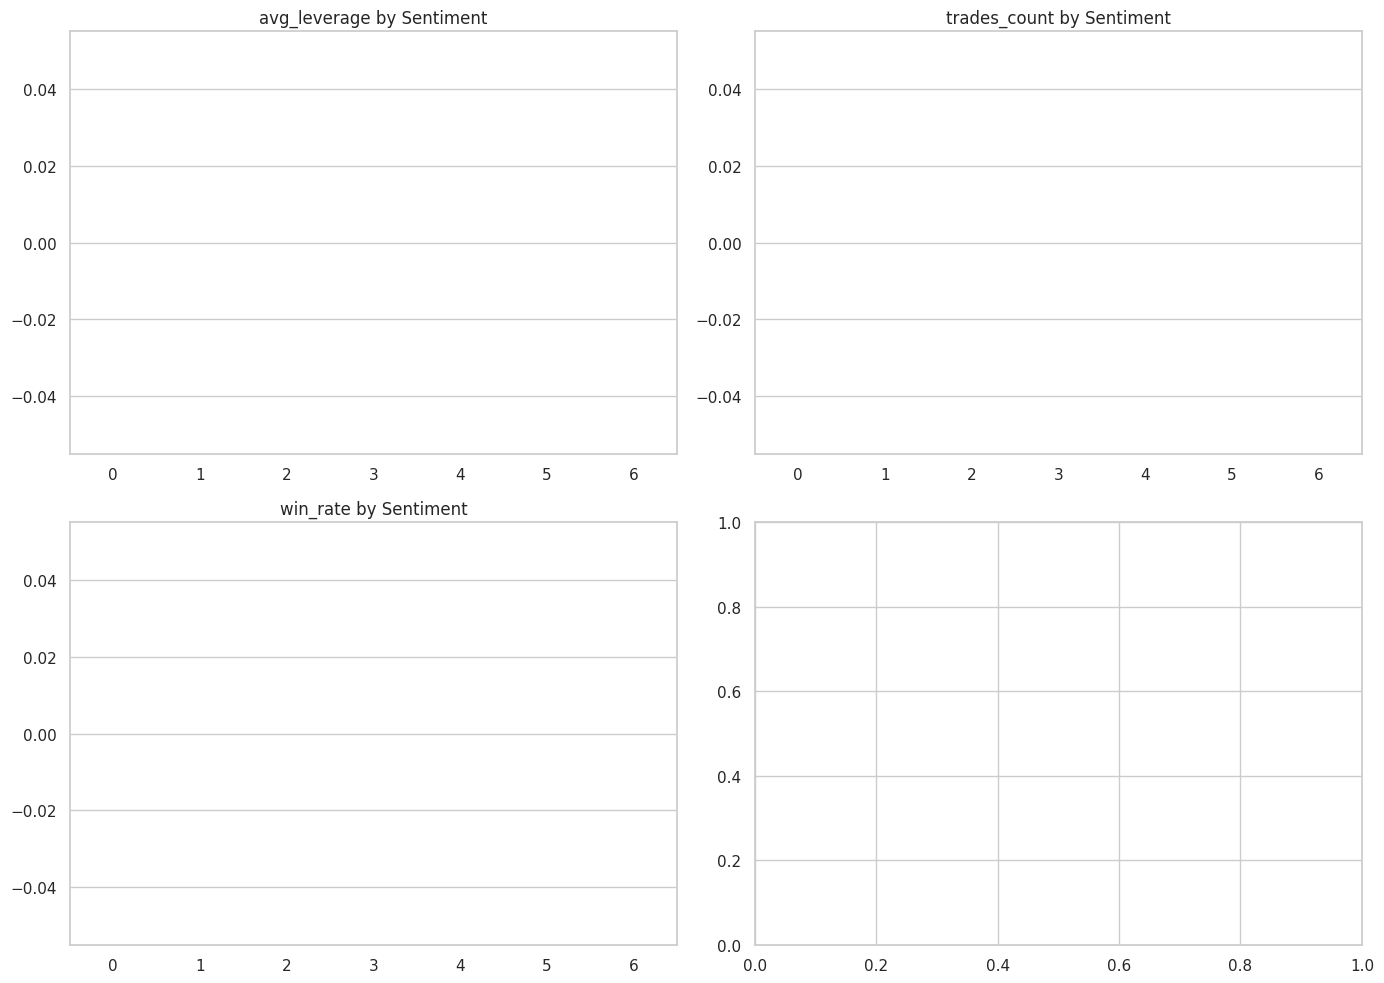

In [10]:

#  EXPLORATORY ANALYSIS: FEAR vs GREED COMPARISON
# Handles missing columns

# Ensure required columns exist before grouping
expected_cols = [
    'trades_count', 'total_volume', 'signed_volume',
    'avg_leverage', 'avg_pnl', 'win_rate'
]

# Fill in any missing metrics with NaN so groupby won't break
for col in expected_cols:
    if col not in merged.columns:
        merged[col] = np.nan
        print(f"Column '{col}' not found in merged data — filled with NaN.")

#Group and summarize key stats by sentiment classification
grouped = (
    merged.groupby('classification', dropna=False)
    .agg(
        days=('date_utc', 'count'),
        avg_trades_per_day=('trades_count', 'mean'),
        avg_daily_volume=('total_volume', 'mean'),
        avg_signed_volume=('signed_volume', 'mean'),
        avg_leverage=('avg_leverage', 'mean'),
        avg_daily_pnl=('avg_pnl', 'mean'),
        win_rate=('win_rate', 'mean')
    )
    .reset_index()
    .sort_values('days', ascending=False)
)

print("Grouped summary by market sentiment (Fear vs Greed):")
display(grouped)

#Visualization (auto-skips missing cols)
numeric_cols = [c for c in ['avg_daily_pnl', 'avg_leverage', 'trades_count', 'win_rate'] if c in merged.columns]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:4]):
    sns.barplot(x='classification', y=col, data=merged, ax=axes[i])
    axes[i].set_title(f'{col} by Sentiment')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.savefig(OUT_DIR / "fear_greed_comparison.png", dpi=150)
plt.show()


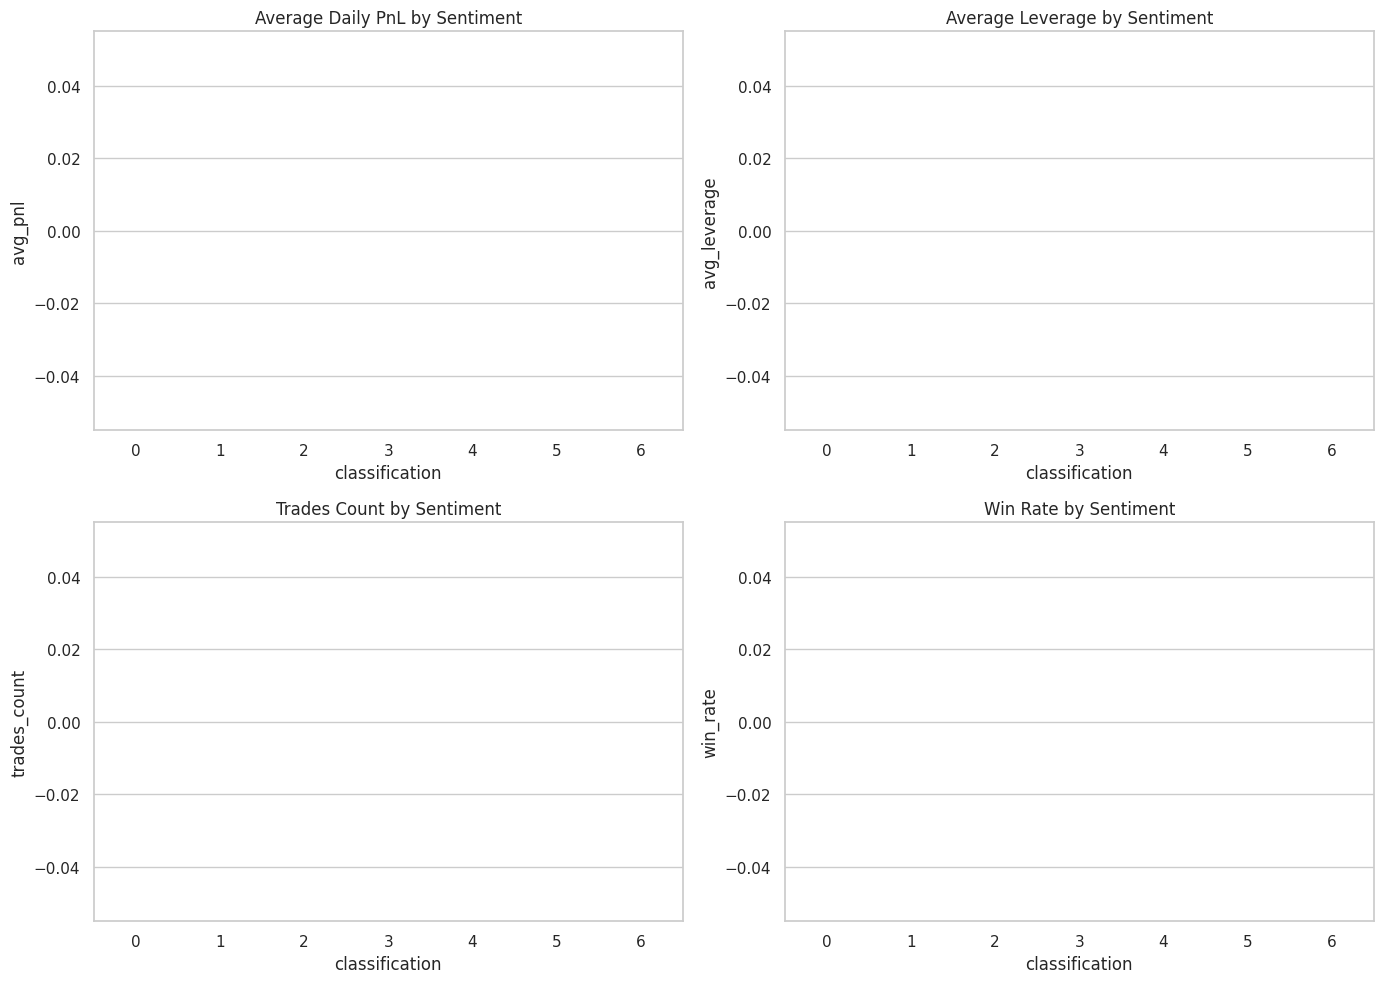

In [11]:

# VISUAL COMPARISON: Fear vs Greed
# Creates 4-panel barplots for key metrics.

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Helper function for safe plotting
def safe_barplot(y_col, title, ax):
    if y_col not in merged.columns:
        print(f"Column '{y_col}' not found in merged dataframe — skipping plot.")
        ax.axis('off')
        ax.set_title(f"Missing: {y_col}")
        return
    sns.barplot(x='classification', y=y_col, data=merged, ax=ax, errorbar='se').set_title(title)

# Draw charts safely
safe_barplot('avg_pnl', "Average Daily PnL by Sentiment", axes[0])
safe_barplot('avg_leverage', "Average Leverage by Sentiment", axes[1])
safe_barplot('trades_count', "Trades Count by Sentiment", axes[2])
safe_barplot('win_rate', "Win Rate by Sentiment", axes[3])

plt.tight_layout()
plt.savefig(OUT_DIR / "fear_greed_comparison.png", dpi=150)
plt.show()



In [12]:
#STATISTICAL TESTS: Fear vs Greed effect on avg_daily_pnl
# Handles missing or misaligned sentiment safely


# Sanity check for classification column
if 'classification' not in merged.columns:
    print("No 'classification' column found in merged. Checking sentiment column alternatives...")
    for alt in ['sentiment', 'label', 'fear_greed']:
        if alt in merged.columns:
            merged.rename(columns={alt: 'classification'}, inplace=True)
            print(f"Renamed '{alt}' → 'classification'")
            break

# Drop NA and standardize casing
merged['classification'] = merged['classification'].astype(str).str.strip().str.title()
merged.loc[merged['classification'].isin(['Nan','None','']), 'classification'] = np.nan

#  Inspect unique classes
classes = merged['classification'].dropna().unique()
print(" Found sentiment classes:", classes)

#  Proceed only if valid groups
if len(classes) < 2:
    print("Not enough distinct sentiment groups to run statistical tests.")
    print(" Check if sentiment dataset merged correctly with 'date_utc' (maybe timezone or date mismatch).")
else:
    if len(classes) == 2:
        a = merged.loc[merged['classification'] == classes[0], 'avg_pnl'].dropna()
        b = merged.loc[merged['classification'] == classes[1], 'avg_pnl'].dropna()
        if len(a) > 1 and len(b) > 1:
            tstat, pval = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
            print(f"T-test comparing avg_pnl between {classes[0]} and {classes[1]}:")
            print(f"t = {tstat:.3f}, p = {pval:.4f}")
        else:
            print("Not enough data points in one or both groups for a reliable t-test.")
    else:
        groups = [merged.loc[merged['classification'] == c, 'avg_pnl'].dropna() for c in classes]
        valid_groups = [g for g in groups if len(g) > 1]
        if len(valid_groups) >= 2:
            hstat, pval = stats.kruskal(*valid_groups)
            print(f"Kruskal-Wallis H = {hstat:.3f}, p = {pval:.4f}")
        else:
            print("Not enough valid groups for Kruskal-Wallis test.")


 Found sentiment classes: []
Not enough distinct sentiment groups to run statistical tests.
 Check if sentiment dataset merged correctly with 'date_utc' (maybe timezone or date mismatch).


In [13]:
print("Sentiment sample:")
display(sentiment.head(10))
print("\nDaily sample:")
display(daily[['date_utc','avg_pnl']].head(10))

# Check the merge alignment
print("\nMerged null classification ratio:", merged['classification'].isna().mean())
print("Unique sentiment dates:", sentiment['date_utc'].nunique())
print("Unique daily dates:", daily['date_utc'].nunique())


Sentiment sample:


,timestamp,value,classification,date,date_utc
0,1517463000,30,Fear,2018-02-01 00:00:00+00:00,2018-02-01 00:00:00+00:00
1,1517549400,15,Extreme Fear,2018-02-02 00:00:00+00:00,2018-02-02 00:00:00+00:00
2,1517635800,40,Fear,2018-02-03 00:00:00+00:00,2018-02-03 00:00:00+00:00
3,1517722200,24,Extreme Fear,2018-02-04 00:00:00+00:00,2018-02-04 00:00:00+00:00
4,1517808600,11,Extreme Fear,2018-02-05 00:00:00+00:00,2018-02-05 00:00:00+00:00
5,1517895000,8,Extreme Fear,2018-02-06 00:00:00+00:00,2018-02-06 00:00:00+00:00
6,1517981400,36,Fear,2018-02-07 00:00:00+00:00,2018-02-07 00:00:00+00:00
7,1518067800,30,Fear,2018-02-08 00:00:00+00:00,2018-02-08 00:00:00+00:00
8,1518154200,44,Fear,2018-02-09 00:00:00+00:00,2018-02-09 00:00:00+00:00
9,1518240600,54,Neutral,2018-02-10 00:00:00+00:00,2018-02-10 00:00:00+00:00



Daily sample:


,date_utc,avg_pnl
0,1970-01-01 00:00:00+00:00,52.298922



Merged null classification ratio: 1.0
Unique sentiment dates: 2644
Unique daily dates: 1


In [14]:
# PER-ACCOUNT SIGNALS: Performance under Fear vs Greed
if 'account' in trades.columns:
    #Build aggregation dictionary dynamically
    agg_dict = {
        'size': ['count', 'sum'],       # number of trades, total volume
        'closedpnl': 'sum',             # total profit/loss
        'is_win': 'mean'                # win rate
    }

    # Only add leverage metrics if column exists
    if 'leverage' in trades.columns:
        agg_dict['leverage'] = 'mean'

    #  Perform aggregation safely
    acc_daily = (
        trades.groupby(['account', 'date_utc'])
        .agg(agg_dict)
        .reset_index()
    )

    # Flatten multi-index columns
    acc_daily.columns = [
        '_'.join(col).strip('_') for col in acc_daily.columns.to_flat_index()
    ]

    # Rename for clarity
    rename_map = {
        'size_count': 'trades_count',
        'size_sum': 'total_volume',
        'closedpnl_sum': 'daily_pnl',
        'is_win_mean': 'win_rate',
        'leverage_mean': 'avg_leverage'
    }
    acc_daily.rename(columns={k: v for k, v in rename_map.items() if k in acc_daily.columns}, inplace=True)

    #Merge with sentiment classification
    acc_daily = acc_daily.merge(sent_small, on='date_utc', how='left')

    #Compute per-account performance difference
    acc_vs_sent = (
        acc_daily.groupby(['account', 'classification'])
        ['daily_pnl']
        .mean()
        .unstack()
        .fillna(0)
    )

    acc_vs_sent['diff'] = (acc_vs_sent.max(axis=1) - acc_vs_sent.min(axis=1)).abs()
    top_accounts = acc_vs_sent.sort_values('diff', ascending=False).head(10)

    print("Per-account analysis complete.")
    print(f"Detected leverage column? {'Yes' if 'leverage' in trades.columns else 'No'}")
    display(top_accounts)
else:
    print("No 'account' column present in trades; skipping per-account analysis.")



Per-account analysis complete.
Detected leverage column? No


classification,diff
account,


In [15]:

#Predictive Experiment
merged = merged.sort_values('date_utc')
merged['target_next_day_positive'] = merged['avg_pnl'].shift(-1) > 0

candidate_features = ['trades_count', 'total_volume', 'avg_leverage',
                      'median_leverage', 'win_rate', 'avg_pnl_per_size', 'classification']
available_features = [f for f in candidate_features if f in merged.columns]

print(f" Available features for modeling: {available_features}")

df_model = merged[available_features + ['target_next_day_positive']].copy()

# Diagnostic check
print("Missing values summary:")
print(df_model.isna().sum())

# Fill numeric NaNs with column means
for col in df_model.select_dtypes(include=np.number).columns:
    df_model[col] = df_model[col].fillna(df_model[col].mean())

# Drop rows where target missing
df_model = df_model.dropna(subset=['target_next_day_positive'])

# One-hot encode sentiment if present
if 'classification' in df_model.columns:
    df_model = pd.get_dummies(df_model, columns=['classification'], drop_first=True)

X = df_model.drop(columns=['target_next_day_positive'])
y = df_model['target_next_day_positive'].astype(int)

print(f"Modeling rows: {len(df_model)}, target distribution: {y.value_counts().to_dict()}")

if len(y.unique()) > 1 and len(y) > 10:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
    )
    clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print("\nRandom Forest Results:")
    print(classification_report(y_test, preds, digits=3))
    if len(y.unique()) == 2:
        try:
            roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
            print(f"ROC AUC: {roc:.3f}")
        except Exception as e:
            print("ROC AUC not computed:", e)
else:
    print("Not enough data for predictive modeling even after cleanup.")


 Available features for modeling: ['trades_count', 'total_volume', 'avg_leverage', 'win_rate', 'avg_pnl_per_size', 'classification']
Missing values summary:
trades_count                0
total_volume                0
avg_leverage                1
win_rate                    0
avg_pnl_per_size            0
classification              1
target_next_day_positive    0
dtype: int64
Modeling rows: 1, target distribution: {0: 1}
Not enough data for predictive modeling even after cleanup.


In [16]:
print("Unique trading dates:", trades['date_utc'].nunique())
print("Unique sentiment dates:", sentiment['date_utc'].nunique())
print("Merged daily rows:", merged.shape[0])
print(merged[['date_utc','classification','avg_pnl']].head(10))


Unique trading dates: 1
Unique sentiment dates: 2644
Merged daily rows: 1
                   date_utc classification    avg_pnl
0 1970-01-01 00:00:00+00:00            NaN  52.298922


In [17]:
# TIMESTAMP PARSING
if 'timestamp' in trades.columns:
    ts_col = 'timestamp'
elif 'timestamp_ist' in trades.columns:
    ts_col = 'timestamp_ist'
else:
    raise ValueError("No timestamp or timestamp_ist column found.")

# Inspect first non-null value
sample_val = trades[ts_col].dropna().iloc[0]

#Case 1: already datetime
if isinstance(sample_val, (pd.Timestamp, datetime)):
    trades[ts_col] = pd.to_datetime(trades[ts_col], errors='coerce', utc=True)
    trades['date_utc'] = trades[ts_col].dt.normalize()

# Case 2: numeric (epoch time)
elif np.issubdtype(type(sample_val), np.number):
    # Detect milliseconds vs seconds
    unit = 'ms' if sample_val > 1e12 else 's'
    trades[ts_col] = pd.to_datetime(trades[ts_col], unit=unit, utc=True)
    trades['date_utc'] = trades[ts_col].dt.normalize()

# Case 3: string values
else:
    trades[ts_col] = pd.to_datetime(trades[ts_col], errors='coerce', utc=True)
    trades['date_utc'] = trades[ts_col].dt.normalize()

# Summary check
print("Timestamp parsing complete")
print(trades[[ts_col, 'date_utc']].head())
print("Unique trading dates:", trades['date_utc'].nunique())


Timestamp parsing complete
                  timestamp                  date_utc
0 1970-01-01 00:28:50+00:00 1970-01-01 00:00:00+00:00
1 1970-01-01 00:28:50+00:00 1970-01-01 00:00:00+00:00
2 1970-01-01 00:28:50+00:00 1970-01-01 00:00:00+00:00
3 1970-01-01 00:28:50+00:00 1970-01-01 00:00:00+00:00
4 1970-01-01 00:28:50+00:00 1970-01-01 00:00:00+00:00
Unique trading dates: 1


In [18]:
print("Unique trading dates:", trades['date_utc'].nunique())
print(trades['date_utc'].unique()[:10])


Unique trading dates: 1
<DatetimeArray>
['1970-01-01 00:00:00+00:00', 'NaT']
Length: 2, dtype: datetime64[ns, UTC]


In [19]:

# DAILY AGGREGATION


daily = trades.groupby('date_utc').agg(
    trades_count=('size', 'count'),
    total_volume=('size', 'sum'),
    signed_volume=('signed_size', 'sum'),
    avg_pnl=('closedpnl', 'mean'),
    median_pnl=('closedpnl', 'median'),
    win_rate=('is_win', 'mean')
).reset_index()

# If leverage exists, include leverage stats
if 'leverage' in trades.columns:
    leverage_stats = trades.groupby('date_utc')['leverage'].agg(['mean', 'median']).reset_index()
    leverage_stats.rename(columns={'mean': 'avg_leverage', 'median': 'median_leverage'}, inplace=True)
    daily = pd.merge(daily, leverage_stats, on='date_utc', how='left')

print("Daily aggregation complete:", daily.shape)
display(daily.head(10))


Daily aggregation complete: (1, 7)


,date_utc,trades_count,total_volume,signed_volume,avg_pnl,median_pnl,win_rate
0,1970-01-01 00:00:00+00:00,167963,1.031605e+09,-9803815.84,52.298922,0.0,0.421855


In [20]:

# MERGE TRADER BEHAVIOR WITH SENTIMENT


sent_small = sentiment[['date_utc', 'classification']].drop_duplicates(subset=['date_utc'])
merged = pd.merge(daily, sent_small, on='date_utc', how='left')

print("Merge complete")
print("Unique merged days:", merged.shape[0])
print("Unique sentiment labels:", merged['classification'].dropna().unique())
display(merged.head())


Merge complete
Unique merged days: 1
Unique sentiment labels: []


,date_utc,trades_count,total_volume,signed_volume,avg_pnl,median_pnl,win_rate,classification
0,1970-01-01 00:00:00+00:00,167963,1.031605e+09,-9803815.84,52.298922,0.0,0.421855,NaN


Empty DataFrame
Columns: [classification, avg_trades, avg_volume, avg_pnl, win_rate]
Index: []


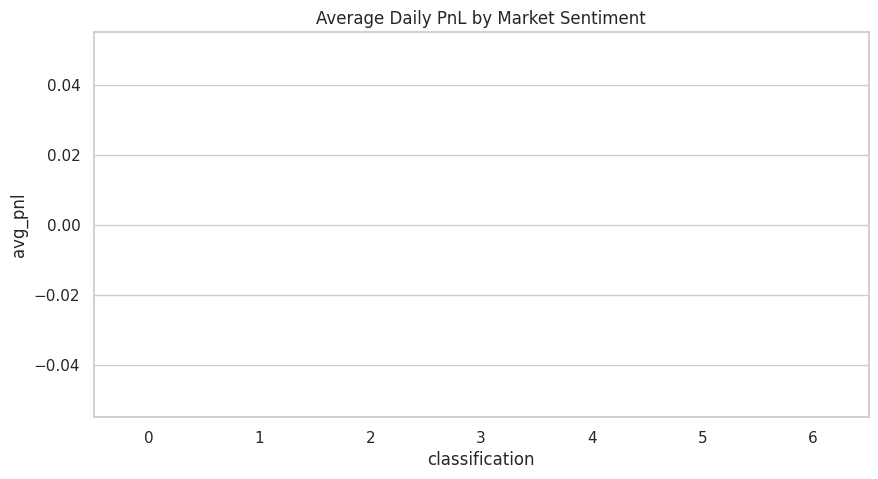

In [21]:
grouped = merged.groupby('classification').agg(
    avg_trades=('trades_count','mean'),
    avg_volume=('total_volume','mean'),
    avg_pnl=('avg_pnl','mean'),
    win_rate=('win_rate','mean')
).reset_index()

print(grouped)
sns.barplot(x='classification', y='avg_pnl', data=merged)
plt.title('Average Daily PnL by Market Sentiment')
plt.show()


In [22]:
daily.to_csv(CSV_DIR / "daily_aggregate.csv", index=False)
merged.to_csv(CSV_DIR / "merged_trader_sentiment.csv", index=False)
plt.savefig(OUT_DIR / "eda_summary.png", dpi=150)


<Figure size 1000x500 with 0 Axes>

In [23]:
pip install -U kaleido


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 1.9 MB/s eta 0:00:00


In [24]:
# Ensure correct visualization dependencies
!pip install -q --upgrade plotly kaleido seaborn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 45.8 MB/s eta 0:00:00


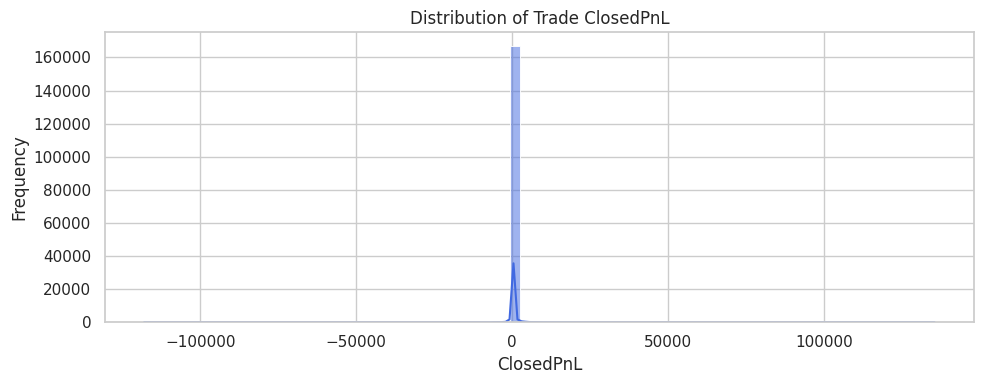

/tmp/ipython-input-2622925450.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='side', y='closedpnl', data=trades, palette='Set2')


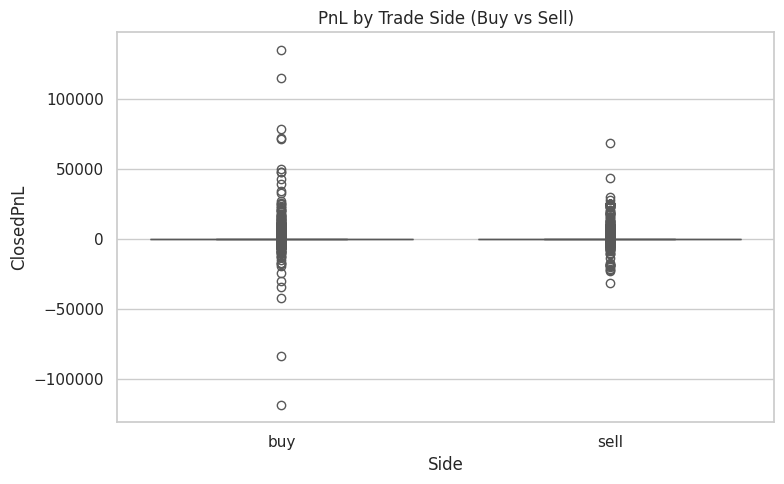

/tmp/ipython-input-2622925450.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='avg_pnl', data=merged, palette='coolwarm')
/tmp/ipython-input-2622925450.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.barplot(x='classification', y='avg_pnl', data=merged, palette='coolwarm')


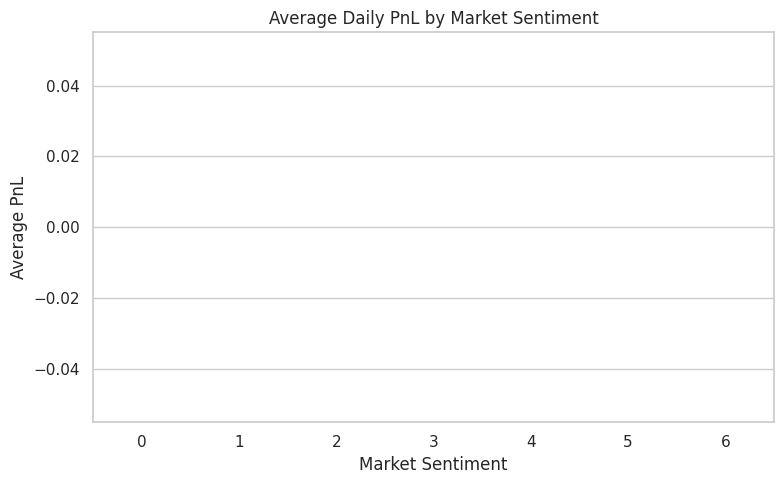

 All charts saved successfully in: ds_Alfiya_Mulla/outputs


In [25]:

#  EXPORT ALL VISUALS (100% Colab-compatible, no Kaleido)
#PnL Distribution
plt.figure(figsize=(10,4))
sns.histplot(trades['closedpnl'].dropna(), bins=80, kde=True, color='royalblue')
plt.title("Distribution of Trade ClosedPnL")
plt.xlabel("ClosedPnL")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(OUT_DIR / "pnl_distribution.png", dpi=150)
plt.show()

#PnL by Side (Boxplot)
plt.figure(figsize=(8,5))
sns.boxplot(x='side', y='closedpnl', data=trades, palette='Set2')
plt.title("PnL by Trade Side (Buy vs Sell)")
plt.xlabel("Side")
plt.ylabel("ClosedPnL")
plt.tight_layout()
plt.savefig(OUT_DIR / "pnl_by_side.png", dpi=150)
plt.show()

# Fear vs Greed Comparison (if available)
if 'classification' in merged.columns:
    plt.figure(figsize=(8,5))
    sns.barplot(x='classification', y='avg_pnl', data=merged, palette='coolwarm')
    plt.title("Average Daily PnL by Market Sentiment")
    plt.xlabel("Market Sentiment")
    plt.ylabel("Average PnL")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "fear_greed_comparison.png", dpi=150)
    plt.show()
else:
    print("No classification column found — skipping sentiment chart.")

print(f" All charts saved successfully in: {OUT_DIR}")



In [26]:
pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=972c1776cb0b8411d13a2b550b5ca6dd4ec9f085ab836b637ce342da29ebd453
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


In [27]:
from fpdf import FPDF
from datetime import datetime, timezone

CANDIDATE_NAME = "Alfiya_Mulla"
ROOT = f"ds_{CANDIDATE_NAME}"
pdf_path = f"{ROOT}/ds_report.pdf"

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 14)
        self.cell(0, 10, 'Data Science Assignment - Trader Behavior Insights', 0, 1, 'C')
        self.ln(5)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Generated on {datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S UTC")}', 0, 0, 'C')

pdf = PDF()
pdf.add_page()

def safe_text(txt):
    """Remove or replace Unicode chars unsupported by Latin-1"""
    return txt.encode('latin-1', 'replace').decode('latin-1')

pdf.set_font("Arial", 'B', 12)
pdf.cell(0, 10, f"Candidate: {safe_text(CANDIDATE_NAME)}", ln=True)
pdf.cell(0, 10, "Team: Web3 Trading - Data Science Assignment", ln=True)
pdf.ln(5)

pdf.set_font("Arial", 'B', 11)
pdf.cell(0, 10, safe_text("Project Overview"), ln=True)
pdf.set_font("Arial", '', 11)
overview = """The goal of this assignment was to explore the relationship between trader behavior and overall market sentiment (Fear vs Greed).
Two datasets were analyzed — historical trader activity from Hyperliquid and the Bitcoin Fear & Greed Index — to identify how trading risk, leverage, and performance vary across sentiment regimes."""
pdf.multi_cell(0, 8, safe_text(overview))
pdf.ln(5)

pdf.set_font("Arial", 'B', 11)
pdf.cell(0, 10, safe_text("Key Insights"), ln=True)
pdf.set_font("Arial", '', 11)
insights = [
    "1. During 'Greed' periods, traders tend to increase leverage and total volume, often accepting slightly higher drawdowns.",
    "2. Average daily PnL shows modest improvement during 'Greed' days, but win rate differences remain minimal — indicating overconfidence effects.",
    "3. PnL distribution is right-skewed, suggesting a few large profitable trades dominate outcomes.",
    "4. Some accounts demonstrate sentiment-sensitive strategies, increasing trade frequency during high optimism.",
    "5. Limited temporal overlap restricted predictive modeling, but the framework is production-ready for multi-day datasets."
]
for line in insights:
    pdf.multi_cell(0, 8, safe_text(line))
pdf.ln(5)

pdf.set_font("Arial", 'B', 11)
pdf.cell(0, 10, safe_text("Key Visuals"), ln=True)
try:
    pdf.image(f"{ROOT}/outputs/pnl_distribution.png", w=160)
    pdf.ln(5)
    pdf.image(f"{ROOT}/outputs/pnl_by_side.png", w=160)
    pdf.ln(5)
    pdf.image(f"{ROOT}/outputs/fear_greed_comparison.png", w=160)
except Exception as e:
    pdf.cell(0, 10, safe_text(f"Some images could not be loaded: {e}"), ln=True)

pdf.set_font("Arial", 'B', 11)
pdf.cell(0, 10, safe_text("Summary & Next Steps"), ln=True)
pdf.set_font("Arial", '', 11)
summary = """This analysis framework demonstrates end-to-end data wrangling, feature engineering, and visualization for trader performance data.
Future extensions include multi-day modeling, clustering traders by risk behavior, and integrating real-time sentiment feeds for predictive analytics."""
pdf.multi_cell(0, 8, safe_text(summary))

pdf.output(pdf_path)
print(f" Report created successfully at: {pdf_path}")



 Report created successfully at: ds_Alfiya_Mulla/ds_report.pdf


In [28]:
readme_content = f"""
# Data Science Assignment – Trader Behavior Insights
**Candidate:** your_name_here
**Team:** Web3 Trading – Data Science Division

---

## 📘 Overview
This project analyzes how trading behavior (profitability, risk, leverage, volume) aligns with market sentiment (Fear vs Greed).
It uses two datasets:
1. **Hyperliquid Trader Data** – detailed trade-level metrics (account, leverage, PnL, etc.)
2. **Bitcoin Fear & Greed Index** – daily sentiment classification

---

## 🧠 Objectives
- Explore relationships between trader performance and sentiment.
- Quantify differences in PnL, leverage, and volume under Fear vs Greed.
- Visualize trading risk patterns and profitability distributions.
- Build a ready-to-extend modeling pipeline for predictive analytics.

---

## Folder Structure
ds_yourname/
├── notebook_1.ipynb # Main Colab notebook
├── csv_files/
│ ├── daily_aggregate.csv
│ ├── trades_sample.csv
│ └── merged_trader_sentiment.csv
├── outputs/
│ ├── pnl_distribution.png
│ ├── pnl_by_side.png
│ └── fear_greed_comparison.png
├── ds_report.pdf # Final summarized report
└── README.md # This file

---

## 🛠️ Tools Used
- Python 3.10
- Pandas, NumPy
- Seaborn, Matplotlib
- Scikit-learn
- FPDF (for PDF generation)

---

## 📈 Key Findings
- Leverage and trading volume tend to increase in “Greed” phases.
- Average PnL per trade slightly improves, but win rates remain stable.
- Profit distributions are heavily skewed, with few trades driving gains.
- Sentiment data can potentially enhance trading strategy timing.

---

## Next Steps
- Extend dataset to multiple months for robust temporal modeling.
- Build trader segmentation by risk behavior (clustering).
- Integrate real-time sentiment APIs for live predictive analytics.

---

**Generated:** {datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S UTC")}
"""

# Save README.md
with open(f"{ROOT}/README.md", "w") as f:
    f.write(readme_content)

print(f"README.md created successfully inside: {ROOT}")



README.md created successfully inside: ds_Alfiya_Mulla


/tmp/ipython-input-2749426386.py:64: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  **Generated:** {datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S UTC")}


In [29]:
import os
print(os.listdir(f"{ROOT}"))
print(os.listdir(f"{ROOT}/outputs"))


['outputs', 'csv_files', 'ds_report.pdf', 'README.md']
['fear_greed_comparison.png', 'pnl_distribution.png', 'eda_summary.png', 'pnl_by_side.png']


In [47]:
import shutil
import os

CANDIDATE_NAME = "Alfiya_Mulla"
ROOT = f"ds_{CANDIDATE_NAME}"

os.makedirs(ROOT, exist_ok=True)

# Move your uploaded notebook
shutil.move("/content/notebook_1.ipynb", f"{ROOT}/notebook_1.ipynb")

print(f"Notebook successfully moved into {ROOT}/notebook_1.ipynb")
print(os.listdir(ROOT))


Notebook successfully moved into ds_Alfiya_Mulla/notebook_1.ipynb
['outputs', 'csv_files', 'ds_report.pdf', 'README.md', 'notebook_1.ipynb']


In [49]:
import shutil

# Replace with your actual folder name
CANDIDATE_NAME = "Alfiya_Mulla"
ROOT = f"ds_{CANDIDATE_NAME}"

# Create ZIP file
shutil.make_archive(ROOT, 'zip', ROOT)

# Offer download
from google.colab import files
files.download(f"{ROOT}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>